# Problem Set 2 - Andreas Bloch

## Data Preprocessing

This function preprocesses the case data and creates various training (and test) sets used in the exercises 1-5. I suggest to skip this step as it will take a long time. To avoid having to do these preprocessing steps every time I already provide the preprocessed datasets in the repository. This allowed me to trin all models with the full dataset (5000 cases).

In [ ]:
if False: # set this to True if you want to preprocess the datasets
    from data_creation_and_loader import create_datasets
    create_datasets()

## Exercise 1 & 5

**Q1:** Take your best hyperparameters for the logistic regression model from Problem Set 1 (or find them with a new model). Use cross_val_predict() to form model predictions of reversed for each observation. Construct a confusion matrix for the predictions. Report the precision_recall_curve() and roc_curve(). Make a calibration plot (as in Bansak et al 2018, appendix page 24).

**Q5:** Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and sigmoid output layer) in Keras or some other deep learning library. Compare performance. Now add two hidden layers, dropout, and batch normalization. Compare performance.

**A:** I've decided to solve exercise 1 and 5 together, as the models run on the same dataset and we were also asked to compare the models (to the one from exercise 1). I'm using the full dataset of ~5'700 cases with each 10'000 features (the number of occurrences of the most popular 3-grams). The evaluation scores for the logistic regression model are reported through cross-validation. The logistic regression model is trained via grid-search. For performance reasons, the evaluation scores for the neural nets are only reported through one validation via a dedicated train and test set and the models aren't trained via grid-search. Unfortunately, all models are as good as a random classifier. Hence, a comparison is rather useless. I've tried a lot of things: from 1'000 to 10'000 features, increasing regularization, ... But all models had an f-score of about 0.5.

### Imports

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l2
from data_creation_and_loader import get_exercise_1_and_5_dataset

Using TensorFlow backend.


### Force CPU to be used

In [3]:
# force keras to use CPU (GPU on shared server is mostly busy)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

### Loading of dataset

In [4]:
# get datasets
X, y = get_exercise_1_and_5_dataset()
y = y.astype(float)

# shuffle the data (again just to make sure)
X, y = shuffle(X, y, random_state=71)

# create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Model definitions

Here's the definition of the logistic regression model. Training with the f1-score (as it's the harmonic mean of precision and reacall) greatly improved the performance of the model (compared to using accuracy as score).

In [5]:
# use logistic regression model
# (specify solver to avoid warnings)
# (increase max_iter to ensure convergence)
log_reg = LogisticRegression(
    solver='liblinear',
    max_iter=10000
)

# specify parameter grid_search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0]
}

# specify grid_search search
grid = GridSearchCV(
    estimator=log_reg,          # estimator to use
    param_grid=param_grid,      # parameters to do grid_search search over
    scoring='f1',               # use F1 score to evaluate models
    n_jobs=4,                   # use 4 cores
    iid=True,                   # assume data was i.i.d. (to avoid warning)
    cv=10,                      # use stratified 10-fold CV
    refit=True,                 # re-fit best model
    verbose=1,                  # do not print training progress
    return_train_score=True     # save training scores
)

Here's the definition of the shallow NN model that replicates logistic regression.

In [6]:
def build_shallow_model():
    shallow_alpha = 0.01
    model = Sequential()
    model.add(Dense(1, input_dim=X.shape[1],
                    activation='sigmoid',
                    kernel_regularizer=l2(shallow_alpha),
                    kernel_initializer='he_normal'))
    print(model.summary())
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model

# build shallow model
shallow_model = KerasClassifier(build_shallow_model)

Here's the definition of the deep NN model.

In [7]:
def build_deep_model():
    deep_alpha = 0.1
    model = Sequential()
    model.add(Dense(int(X.shape[1]*.75),
                    input_dim=X.shape[1],
                    activation='sigmoid',
                    kernel_regularizer=l2(deep_alpha),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(int(X.shape[1]*.5),
                    activation='sigmoid',
                    kernel_regularizer=l2(deep_alpha),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dense(1,
                    activation='sigmoid',
                    kernel_regularizer=l2(deep_alpha),
                    kernel_initializer='he_normal'))
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# build deep model
deep_model = KerasClassifier(build_deep_model)

### Training

In [8]:
# train logistic regression with grid_search
grid.fit(X, y)

# report best hyperparameters
print('Best Hyperparameters:')
print(grid.best_params_)
print('')

# report the best score
print('Best Score:')
print(grid.best_score_)
print('')

# keep track of best model
best_log_reg_model = grid.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min


Best Hyperparameters:
{'penalty': 'l1', 'C': 0.01}

Best Score:
0.7745155904918126



[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.7min finished


In [9]:
# train shallow model
EPOCHS_SHALLOW = 50
BATCH_SIZE_SHALLOW = 64
shallow_model.fit(X_train, y_train, epochs=EPOCHS_SHALLOW, batch_size=BATCH_SIZE_SHALLOW, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
4609/4609 [==============================] - 1s 158us/step - loss: 0.7889 - acc: 0.5613
Epoch 2/50
4609/4609 [==============================] - 1s 112us/step - loss: 0.4577 - acc: 0.7924
Epoch 3/50
4609/4609 [==============================] - 1s 113us/step - loss: 0.3642 - acc: 0.8720
Epoch 4/50
4609/4609 [==============================] - 0s 108us/step - loss: 0.3162 - acc: 0.9006
Epoch 5/50
4609/4609 [==============================] - 1s 114us/step - loss: 0.2865 - acc: 0.9212
Epoch 6/50
4609/4609 [==============================] - 1s 109us/step - loss: 0.2678 - acc: 0.9362
Epoch 7/50
4609/4609 [==============================] - 1s 110us/st

In [12]:
# train deep model
EPOCHS_DEEP = 1
BATCH_SIZE_DEEP = 256
deep_model.fit(X_train, y_train, epochs=EPOCHS_DEEP, batch_size=BATCH_SIZE_DEEP, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7500)              75007500  
_________________________________________________________________
batch_normalization_1 (Batch (None, 7500)              30000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5000)              37505000  
_________________________________________________________________
batch_normalization_2 (Batch (None, 5000)              20000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5001      
Total params: 112,567,501
Trainable params: 112,542,501
Non-trainable params: 25,000
_________________________________________________________

In [13]:
# evaluate linear regression model
y_pred_lr = cross_val_predict(best_log_reg_model, X, y, method='decision_function', cv=10)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)
y_score_lr = best_log_reg_model.decision_function(X_test)
y_proba_pos_lr = (y_score_lr - y_score_lr.min()) / (y_score_lr.max() - y_score_lr.min())
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_score_lr)
average_precision_lr = average_precision_score(y_test, y_score_lr)
CM_lr = confusion_matrix(y, np.heaviside(y_pred_lr, 1).astype(int))
CM_lr = CM_lr.astype('float') / CM_lr.sum(axis=1)[:, np.newaxis]

In [14]:
# evaluate shallow model
y_pred_shallow = shallow_model.predict(X_test) > 0.5
fpr_shallow, tpr_shallow, thresholds_shallow = roc_curve(y_test, y_pred_shallow)
auc_shallow = auc(fpr_shallow, tpr_shallow)
y_proba_pos_shallow = shallow_model.predict_proba(X_test)[:, 1]
precision_shallow, recall_shallow, _ = precision_recall_curve(y_test, y_proba_pos_shallow)
average_precision_shallow = average_precision_score(y_test, y_proba_pos_shallow)
CM_shallow = confusion_matrix(y_test, y_pred_shallow > 0.5)
CM_shallow = CM_shallow.astype('float') / CM_shallow.sum(axis=1)[:, np.newaxis]

In [15]:
# evaluate deep model
y_pred_deep = deep_model.predict(X_test) > 0.5
fpr_deep, tpr_deep, thresholds_deep = roc_curve(y_test, y_pred_deep)
auc_deep = auc(fpr_deep, tpr_deep)
y_proba_pos_deep = deep_model.predict_proba(X_test)[:, 1]
precision_deep, recall_deep, _ = precision_recall_curve(y_test, y_proba_pos_deep)
average_precision_deep = average_precision_score(y_test, y_proba_pos_deep)
CM_deep = confusion_matrix(y_test, y_pred_deep > 0.5)
CM_deep = CM_deep.astype('float') / CM_deep.sum(axis=1)[:, np.newaxis]

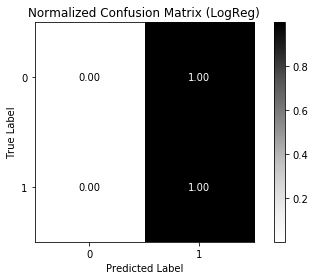

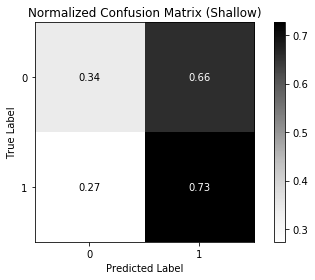

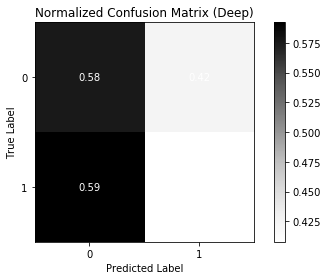

In [19]:
# function to create confusion matrix
def plot_confusion_matrix(CM, name):
    title = 'Normalized Confusion Matrix ('+name+')'
    classes = [0, 1]
    fig, ax = plt.subplots()
    im = ax.imshow(CM, interpolation='nearest', cmap=plt.cm.Greys)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(CM.shape[1]),
           yticks=np.arange(CM.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')
    # color text in confusion matrix appropriately
    fmt = '.2f'
    thresh = CM.max() / 2.
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            ax.text(j, i, format(CM[i, j], fmt),
                    ha="center", va="center",
                    color="white" if CM[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# create confusion matrices
plot_confusion_matrix(CM_lr, name='LogReg')
plot_confusion_matrix(CM_shallow, name='Shallow')
plot_confusion_matrix(CM_deep, name='Deep')

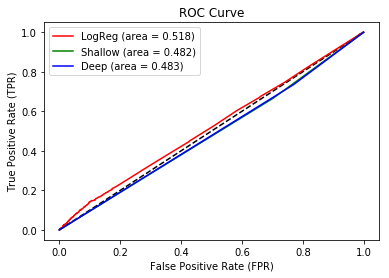

In [12]:
# create ROC plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, color='r', label='LogReg (area = {:.3f})'.format(auc_lr))
plt.plot(fpr_shallow, tpr_shallow, color='g', label='Shallow (area = {:.3f})'.format(auc_shallow))
plt.plot(fpr_deep, tpr_deep, color='b', label='Deep (area = {:.3f})'.format(auc_deep))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

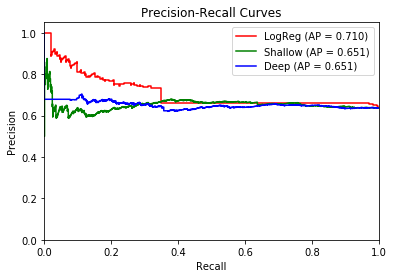

In [17]:
# create precision recall plot
plt.step(recall_lr, precision_lr, color='r', where='post', label='LogReg (AP = {:.3f})'.format(average_precision_lr))
plt.step(recall_shallow, precision_shallow, color='g', where='post', label='Shallow (AP = {:.3f})'.format(average_precision_shallow))
plt.step(recall_deep, precision_deep, color='b', where='post', label='Deep (AP = {:.3f})'.format(average_precision_deep))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.show()

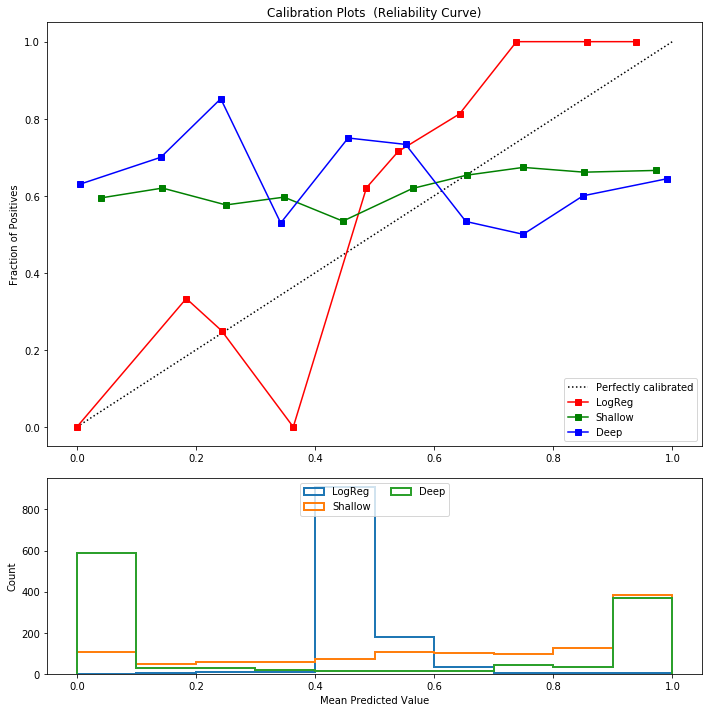

In [18]:
# create calibration plot
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
# create perfectly calibrated model
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
# plot logistic regression
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, y_proba_pos_lr, n_bins=10)
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", color='r', label="%s" % ('LogReg', ))
ax2.hist(y_proba_pos_lr, range=(0, 1), bins=10, label='LogReg', histtype="step", lw=2)
# plot shallow model
fraction_of_positives_shallow, mean_predicted_value_shallow = calibration_curve(y_test, y_proba_pos_shallow, n_bins=10)
ax1.plot(mean_predicted_value_shallow, fraction_of_positives_shallow, "s-", color='g', label="%s" % ('Shallow', ))
ax2.hist(y_proba_pos_shallow, range=(0, 1), bins=10, label='Shallow', histtype="step", lw=2)
# plot deep model
fraction_of_positives_deep, mean_predicted_value_deep = calibration_curve(y_test, y_proba_pos_deep, n_bins=10)
ax1.plot(mean_predicted_value_deep, fraction_of_positives_deep, "s-", color='b', label="%s" % ('Deep', ))
ax2.hist(y_proba_pos_deep, range=(0, 1), bins=10, label='Deep', histtype="step", lw=2)
# name axes
ax1.set_ylabel("Fraction of Positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration Plots  (Reliability Curve)')
ax2.set_xlabel("Mean Predicted Value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.tight_layout()
plt.show()

## Exercise 2

**Q:** Scale your n-gram frequencies while maintaining sparsity, as discussed in class. Train an elastic net model to predict log citations to a case (log_cites). Run cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. 

**A:** The sparsity-preserving scaling was done in the preprocessing (see `data_creation_and_loader.py`). Here's the code for the elastic net model: Previously, I had grid-searched over a large space of alpha values (0.001 to 10). I noticed that a very simall alpha value is required, as we have a lot of parameters, so here the range is reduced from 0.3 to 2.0). Also, models with a smaller l1 ratio tended to work better.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
import numpy as np
from data_creation_and_loader import get_exercise_2_dataset

# load dataset
X, y = get_exercise_2_dataset()

# use only 1'000 features (instead of 10'000)
# the features are sorted by their popularity
X = X[:,0:1000]

# shuffle the data
X, y = shuffle(X, y, random_state=71)

# use elastic net model
# increase max_iter to ensure convergence
elastic_net = ElasticNet(
    max_iter=10000,
    copy_X=False
)

# specify parameter grid_search
param_grid = {
    'alpha': [0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0],
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3]
}

# specify grid_search search
grid_search = GridSearchCV(
    estimator=elastic_net,              # estimator to use
    param_grid=param_grid,              # parameters to do grid search over
    scoring='neg_mean_squared_error',   # use MSE score to evaluate models
    n_jobs=4,                           # use 4 cores
    iid=True,                           # ass. data was i.i.d. (to avoid warn.)
    cv=10,                              # use stratified 10-fold CV
    refit=True,                         # re-fit best model
    verbose=1,                          # do not print training progress
    return_train_score=True             # save training scores
)

# train with grid_search-search
grid_search.fit(X, y)
print('')

# report best hyperparameters
print('Best Hyperparameters:')
print(grid_search.best_params_)
print('')

# report the best score
print('Best Score:')
print(grid_search.best_score_)
print('')

# keep track of best model
best_elastic_net_model = grid_search.best_estimator_

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   35.2s finished



Best Hyperparameters:
{'alpha': 0.7, 'l1_ratio': 0.01}

Best Score:
-0.7154045675790107



No handles with labels found to put in legend.


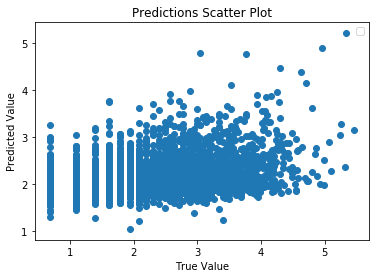

In [5]:
# run cross-val predictions
y_pred = cross_val_predict(best_elastic_net_model, X, y, cv=10)

# print scatter plot
plt.scatter(y, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predictions Scatter Plot')
plt.legend(loc='best')
plt.show()

This is the scatter plot produced by the best model. As we can see we have a lot of variance in the predictions. It also seems that the model It might be that the features aren't predictive for the number of cites. Further enhancing the scatter plot with the density shows us that the model doesn't really succeed well to predict higher `log_cites` values. 

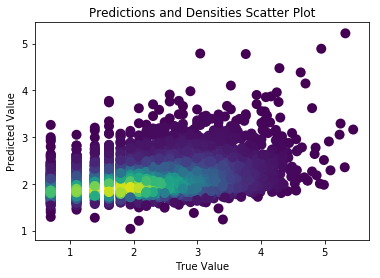

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

xy = np.vstack([y,y_pred])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(y, y_pred, c=z, s=100, edgecolor='')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predictions and Densities Scatter Plot')
plt.show()

## Exercise 3

**Q:** Use the judge identifiers (judge_id) to produce the average citations to cases for each judge. Then estimate a two-stage least-squares model with Z as average citations of the judge, X as citations to the case, and Y as whether the case was reversed. Include year fixed effects. You can do this in two stages, by regressing X on Z to get Xpred, and then regressing Y on Xpred. Report estimates for coefficient and standard error on Xpred. Compare to the parameter estimates for the OLS regression of Y on X.

https://github.com/ellliottt/fiscal_policy_course/blob/master/notebooks/20-Instrumental-Variables.ipynb

In [ ]:
from linearmodels.iv import IV2SLS
from data_creation_and_loader import get_exercise_3_dataframe

# get the data
df = get_exercise_3_dataframe()

# 2SLS
#     Ypred :=     Y   regressed on   Xpred := (X     regressed on Z)
formula_2sls = 'case_reversed ~ 1 + C(year) + [cites_case ~ avg_cites_judge]'
predictor_2sls = IV2SLS.from_formula(formula_2sls, data=df)
results_2sls = predictor_2sls.fit()

# OLS
#     Ypred :=     Y   regressed on             X
formula_ols = 'case_reversed ~ 1 + C(year) + cites_case'
predictor_ols = IV2SLS.from_formula(formula_ols, data=df)
results_ols = predictor_ols.fit()

**A:** The tables below show the results of the parameter estimates.

The estimates for the coefficient and standard error for Xpred (cites_case) in the 2SLS are:

    Parameter  Std. Err.   T-stat	P-value	 Lower CI	Upper CI
    -0.0070     0.0012	 -5.8450	0.0000	 -0.0093	 -0.0046
    
The estimates for the coefficient and standard error for X (cites_case) in the 2SLS are:

    Parameter	Std. Err.     T-stat	P-value	 Lower CI	Upper CI
    -0.0032	    0.0005	   -6.5101	0.0000	 -0.0042	-0.0023
    
As we can see the p-values are very low for both regressions. It's unlikely that there is some linear relationship (or two-stage linear relationship) between the variables (as our model (or null hypothesis) assumed). However, the parameters can be estimated quite well in both cases with a very low standard error (and thus we have thight confidence intervals).

In [12]:
results_2sls

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.0415
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0215
No. Observations:                4399   F-statistic:                    295.11
Date:                Wed, Apr 17 2019   P-value (F-stat)                0.0000
Time:                        19:37:01   Distribution:                 chi2(90)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.3750     0.2808     1.3358     0.1816     -0.1752      0.9253
C(year)[T.1925.0]     0.2083     0.2991     0.6964     0.4862     -0.3780      0.7947
C(year)[T.1926.0]     0.2017     0.2983     0.6760     0.4991     -0.3831      0.7864
C(year)[T.1927.0]     0.4455     0.2927     1.5222     0.1280     -0.1281      1.0192
C(year)[T.1928.0]     0.3076     0.3007     1.0232     0.3062     -0.2817      0.8969
C(year)[T.1929.0]     0.0989     0.2970     0.3329     0.7392     -0.4832      0.6810
C(year)[T.1930.0]     0.1339     0.2955     0.4532     0.6504     -0.4453      0.7132
C(year)[T.1931.0]     0.0243     0.2945     0.0825     0.9342     -0.5529      0.6015
C(year)[T.1932.0]     0.0076     0.2890     0.0262     0.9791     -0.5589      0.5740
C(year)[T.1933.0]     0.2035     0.2915     0.6979     0.4852     -0.3679      0.7748
C(year)[T.1934.0]     0.1086     0.2891     0.3758     0.7071     -0.4579      0.6752
C(year)[T.1935.0]    -0.0383     0.2903    -0.1319     0.8951     -0.6074      0.5308
C(year)[T.1936.0]     0.1424     0.2898     0.4912     0.6233     -0.4257      0.7104
C(year)[T.1937.0]     0.3026     0.2890     1.0473     0.2950     -0.2637      0.8690
C(year)[T.1938.0]     0.0296     0.2893     0.1023     0.9185     -0.5374      0.5965
C(year)[T.1939.0]     0.2644     0.2880     0.9180     0.3586     -0.3001      0.8289
C(year)[T.1940.0]     0.2456     0.2865     0.8573     0.3913     -0.3159      0.8070
C(year)[T.1941.0]     0.3122     0.2891     1.0800     0.2801     -0.2544      0.8788
C(year)[T.1942.0]     0.2029     0.2896     0.7006     0.4835     -0.3647      0.7706
C(year)[T.1943.0]     0.2061     0.2902     0.7100     0.4777     -0.3628      0.7750
C(year)[T.1944.0]     0.2325     0.2891     0.8044     0.4212     -0.3341      0.7991
C(year)[T.1945.0]     0.2405     0.2905     0.8278     0.4078     -0.3289      0.8099
C(year)[T.1946.0]     0.1365     0.2909     0.4693     0.6389     -0.4337      0.7067
C(year)[T.1947.0]     0.3026     0.2915     1.0381     0.2992     -0.2687      0.8739
C(year)[T.1948.0]     0.2639     0.2888     0.9139     0.3608     -0.3021      0.8299
C(year)[T.1949.0]     0.2807     0.2919     0.9615     0.3363     -0.2915      0.8529
C(year)[T.1950.0]     0.3361     0.2889     1.1631     0.2448     -0.2302      0.9024
C(year)[T.1951.0]     0.1280     0.2918     0.4388     0.6608     -0.4438      0.6999
C(year)[T.1952.0]     0.2668     0.2920     0.9138     0.3608     -0.3054      0.8390
C(year)[T.1953.0]     0.2313     0.2916     0.7933     0.4276     -0.3402      0.8027
C(year)[T.1954.0]     0.3346     0.2903     1.1525     0.2491     -0.2344      0.9037
C(year)[T.1955.0]     0.2878     0.2892     0.9951     0.3197     -0.2791      0.8546
C(year)[T.1956.0]     0.2477     0.2869     0.8635     0.3879     -0.3146      0.8101
C(year)[T.1957.0]     0.2407     0.2897     0.8308     0.4061     -0.3272      0.8086
C(year)[T.1958.0]     0.3178     0.2877     1.1

In [11]:
results_ols

OLS Estimation Summary                            
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.0566
Estimator:                        OLS   Adj. R-squared:                 0.0369
No. Observations:                4399   F-statistic:                    297.87
Date:                Wed, Apr 17 2019   P-value (F-stat)                0.0000
Time:                        19:37:01   Distribution:                 chi2(90)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.3527     0.2761     1.2774     0.2015     -0.1885      0.8940
C(year)[T.1925.0]     0.2104     0.2954     0.7122     0.4763     -0.3686      0.7893
C(year)[T.1926.0]     0.2052     0.2942     0.6977     0.4854     -0.3713      0.7818
C(year)[T.1927.0]     0.4404     0.2882     1.5279     0.1265     -0.1245      1.0053
C(year)[T.1928.0]     0.3125     0.2962     1.0550     0.2914     -0.2680      0.8930
C(year)[T.1929.0]     0.1030     0.2931     0.3516     0.7251     -0.4713      0.6774
C(year)[T.1930.0]     0.1323     0.2915     0.4540     0.6498     -0.4390      0.7037
C(year)[T.1931.0]     0.0240     0.2904     0.0828     0.9340     -0.5451      0.5932
C(year)[T.1932.0]     0.0035     0.2847     0.0124     0.9901     -0.5546      0.5616
C(year)[T.1933.0]     0.2105     0.2871     0.7332     0.4634     -0.3522      0.7733
C(year)[T.1934.0]     0.0998     0.2850     0.3503     0.7261     -0.4587      0.6584
C(year)[T.1935.0]    -0.0371     0.2861    -0.1296     0.8968     -0.5977      0.5236
C(year)[T.1936.0]     0.1442     0.2854     0.5053     0.6133     -0.4151      0.7036
C(year)[T.1937.0]     0.3048     0.2844     1.0716     0.2839     -0.2527      0.8623
C(year)[T.1938.0]     0.0331     0.2850     0.1163     0.9074     -0.5255      0.5917
C(year)[T.1939.0]     0.2599     0.2837     0.9161     0.3596     -0.2961      0.8159
C(year)[T.1940.0]     0.2355     0.2820     0.8351     0.4036     -0.3172      0.7881
C(year)[T.1941.0]     0.3093     0.2845     1.0871     0.2770     -0.2483      0.8668
C(year)[T.1942.0]     0.1952     0.2855     0.6836     0.4942     -0.3644      0.7547
C(year)[T.1943.0]     0.2037     0.2861     0.7118     0.4766     -0.3571      0.7645
C(year)[T.1944.0]     0.2179     0.2846     0.7657     0.4439     -0.3399      0.7756
C(year)[T.1945.0]     0.2321     0.2861     0.8112     0.4173     -0.3287      0.7929
C(year)[T.1946.0]     0.1331     0.2867     0.4642     0.6425     -0.4289      0.6950
C(year)[T.1947.0]     0.2987     0.2875     1.0387     0.2989     -0.2649      0.8622
C(year)[T.1948.0]     0.2547     0.2846     0.8950     0.3708     -0.3030      0.8124
C(year)[T.1949.0]     0.2643     0.2878     0.9184     0.3584     -0.2997      0.8283
C(year)[T.1950.0]     0.3081     0.2845     1.0830     0.2788     -0.2495      0.8656
C(year)[T.1951.0]     0.1126     0.2876     0.3914     0.6955     -0.4511      0.6762
C(year)[T.1952.0]     0.2578     0.2878     0.8957     0.3704     -0.3063      0.8219
C(year)[T.1953.0]     0.1827     0.2872     0.6360     0.5248     -0.3803      0.7456
C(year)[T.1954.0]     0.3029     0.2855     1.0610     0.2887     -0.2567      0.8625
C(year)[T.1955.0]     0.2787     0.2849     0.9784     0.3279     -0.2796      0.8370
C(year)[T.1956.0]     0.2349     0.2824     0.8319     0.4054     -0.3186      0.7885
C(year)[T.1957.0]     0.2296     0.2854     0.8044     0.4212     -0.3298      0.7889
C(year)[T.1958.0]     0.3083     0.2831     1.089

## Exercise 4

**Q:** Train LDA on the cases. Produce word clouds for the topics. Inspect the word clouds for different models to decide on the right number of topics.

**A:** I've tried out various numbers of topics. 

* **Many topics (e.g., 10, 15 or 20)**: I noticed that by increasing the number of topics, suddenly, smaller topics (that aren't as dominant in the dataset as others) started to appear. However, I also noticed that I had a lot of overlapping topics.

* **Few topics (e.g., 3, 5, 7)**: When choosing too few topics (=3) then the topics weren't representative and distinguishable enough. I realized that by increasing the number of topics (to 5 or 7) the topics became enough diverse.

I decided to use 5 topics as it seemd to be a good choice for the trade-off between *having enough diversity* and *not having too many overlapping* topics.

As one can see in the results below the topics that can be identified from the clouds are: business related topics (patents, contracts, taxes), law related terms (law, evidence, claim), public services and politics (school, constitution, ...).

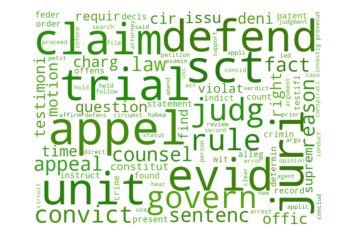

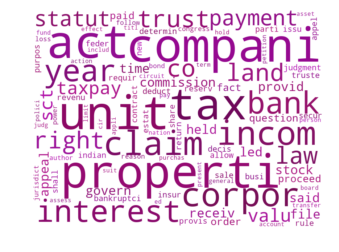

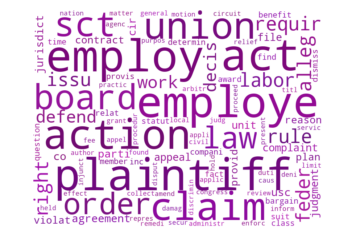

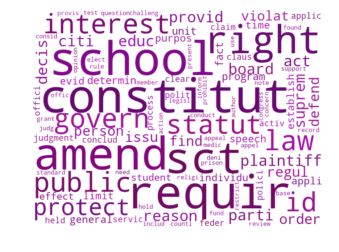

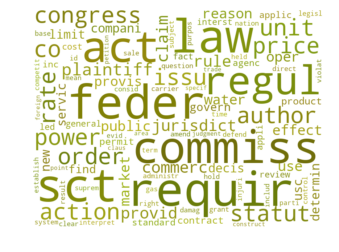

In [15]:
%matplotlib inline
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from data_creation_and_loader import get_exercise_4_list

NUM_TOPICS = 5
NUM_PASSES = 30
NUM_WORDS_PER_WORD_CLOUD = 100

# get dataset
case_token_lists = get_exercise_4_list()

# define function to filter list of words
BAD_WORDS = ['state', 'court', 'case', 'section', 'district']
def filter_words(word):
    if word in BAD_WORDS:
        return False
    return True
filter_list = lambda ls : list(filter(filter_words, ls))
# filter out some words that appear huge in every word cloud
case_token_lists = list(map(filter_list, case_token_lists))

# randomize document order
shuffle(case_token_lists)

# creating the term dictionary
dictionary = Dictionary(case_token_lists)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(case) for case in case_token_lists]

# train LDA
lda = LdaMulticore(doc_term_matrix,
                   num_topics=NUM_TOPICS,
                   id2word=dictionary,
                   passes=NUM_PASSES)

# get the list of topics
topics = lda.show_topics(num_topics=NUM_TOPICS,
                         num_words=NUM_WORDS_PER_WORD_CLOUD,
                         formatted=False)

# show the word cloud for each topic
for topic_idx, word_weights in topics:

    # use logarithmic weights to balance out outliers
    logweights = [(w[0], np.log(w[1])) for w in word_weights]

    # sample a random color for the topic
    maincol = randint(0, 360)
    # create a coloring function
    def colorfunc(word=None,
                  font_size=None,
                  position=None,
                  orientation=None,
                  font_path=None,
                  random_state=None):
        # get a color near to the main color
        color = randint(maincol - 10, maincol + 10)
        # adjust color via modulus
        if color < 0:
            color = 360 + color
        # generate color string
        # format (hue (color), saturation%, lightness%, alpha%)
        color_string = 'hsl(%d, %d%%, %d%%)' % \
                       (color,
                        randint(65, 75) + font_size / 7,
                        randint(35, 45) - font_size / 10)
        return color_string

    # initialize word cloud for topic
    # specify color function
    wordcloud = WordCloud(background_color='white',
                          ranks_only=False,
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,
                          width=800)

    # generate the word cloud
    wordcloud.generate_from_frequencies(dict(logweights))

    # plot the word loud
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()